# Glint-FMPair evaluation on 30Music listening histories

In [11]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.driver.memory=40G " + \
    "--conf \"spark.driver.extraJavaOptions=-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35 -XX:-ResizePLAB\" " + \
    "--conf spark.driverEnv.LD_PRELOAD=/opt/cloudera/parcels/mkl/linux/mkl/lib/intel64/libmkl_rt.so " + \
    "--conf spark.driverEnv.MKL_VERBOSE=0 " + \
    "--jars glint-fmpair/target/scala-2.11/glint-fmpair-assembly-1.0.jar pyspark-shell"

import pickle
import random
import time

from math import log2, ceil
from matplotlib import pyplot as plt, patches as mpatches

from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import VectorAssembler, StringIndexer, RegexTokenizer, \
    StopWordsRemover, CountVectorizer, StringIndexerModel, CountVectorizerModel
from pyspark.sql.functions import collect_set, udf, col, mean, first, year, lower, \
    explode, explode_outer, lag, to_timestamp, regexp_replace, posexplode, split, \
    from_json, schema_of_json, lit, coalesce, expr, when, posexplode, \
    count, countDistinct, max as sparkMax, sum as sparkSum
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import IntegerType, StringType, LongType, StructType, StructField, ArrayType

from glintfmpair import WeightHotEncoderEstimator, WeightHotEncoderModel, \
    GlintFMPair, GlintFMPairModel, PopRank, SAGH, KNN, TfIdfKNN

In [2]:
spark = SparkSession.builder \
    .appName("Glint-FMPair evaluation on 30Music") \
    .master("yarn") \
    .config("spark.submit.deployMode","client") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.executor.memory", "25G") \
    .config("spark.yarn.executor.memoryOverhead", "5G") \
    .config("spark.executor.instances", "80") \
    .config("spark.executor.cores", "5") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35 -XX:-ResizePLAB") \
    .config("spark.executorEnv.LD_PRELOAD",
            "/opt/cloudera/parcels/mkl/linux/mkl/lib/intel64/libmkl_rt.so") \
    .config("spark.executorEnv.MKL_VERBOSE", "0") \
    .config("spark.jars", "glint-fmpair/target/scala-2.11/glint-fmpair-assembly-1.0.jar") \
    .config("spark.kryoserializer.buffer.max", "256m") \
    .config("spark.executor.heartbeatInterval", "100000") \
    .config("spark.network.timeout", "1000000") \
    .config("spark.maxRemoteBlockSizeFetchToMem", "256m") \
    .config("spark.driver.maxResultSize", "8G") \
    .config("spark.default.parallelism", "4000") \
    .config("spark.sql.tungsten.enabled", "false") \
    .getOrCreate()
#    .config("spark.sql.shuffle.partitions", "10000") \
#    .config("spark.sql.windowExec.buffer.in.memory.threshold", "1000000") \
#    .config("spark.sql.windowExec.buffer.spill.threshold", "1000000") \

sc = spark.sparkContext

In [3]:
spark.udf.registerJavaFunction("resizeVector", "org.apache.spark.ml.recommendation.ResizeVector", VectorUDT())

In [4]:
sessionsDataPath = "30Music/relations/sessions.idomaar"
playlistsDataPath = "30Music/relations/playlists.idomaar"
tracksDataPath = "30Music/entities/tracks.idomaar"
usersDataPath = "30Music/entities/users.idomaar"

In [5]:
trans=False
valSplit=True

In [6]:
if valSplit:
    if trans:
        indexedTrainDataPath = "30Music-train-trans.parquet"
        indexedValSeedsDataPath = "30Music-valseeds-trans.parquet"
        indexedValDataPath = "30Music-val-trans.parquet"
        indexerModelPathFormat = "30Music-{}-indexer-trans.model"
        encoderModelPaths = ["30Music-usercoldstartencoder-trans.model", "30Music-userencoder-trans.model",
                             "30Music-itemencoder-trans.model", "30Music-ctxitemencoder-trans.model"]
    else:
        indexedTrainDataPath = "30Music-train.parquet"
        indexedValSeedsDataPath = "30Music-valseeds.parquet"
        indexedValDataPath = "30Music-val.parquet"
        indexerModelPathFormat = "30Music-{}-indexer.model"
        encoderModelPaths = ["30Music-usercoldstartencoder.model", "30Music-userencoder.model",
                             "30Music-itemencoder.model", "30Music-ctxitemencoder.model"]
else:
    if trans:
        indexedTrainDataPath = "30Music-test-train-trans.parquet"
        indexedValSeedsDataPath = "30Music-test-valseeds-trans.parquet"
        indexedValDataPath = "30Music-test-val-trans.parquet"
        indexerModelPathFormat = "30Music-test-{}-indexer-trans.model"
        encoderModelPaths = ["30Music-test-usercoldstartencoder-trans.model", "30Music-test-userencoder-trans.model",
                             "30Music-test-itemencoder-trans.model", "30Music-tets-ctxitemencoder-trans.model"]
    else:
        indexedTrainDataPath = "30Music-test-train.parquet"
        indexedValSeedsDataPath = "30Music-test-valseeds.parquet"
        indexedValDataPath = "30Music-test-val.parquet"
        indexerModelPathFormat = "30Music-test-{}-indexer.model"
        encoderModelPaths = ["30Music-test-usercoldstartencoder.model", "30Music-test-userencoder.model",
                             "30Music-test-itemencoder.model", "30Music-test-ctxitemencoder.model"]

In [7]:
parameterServerHost="10.7.0.101"

In [8]:
loadFeatures=False
saveFeatures=False
loadIndexed=False
saveIndexed=False

loadIndexers=False
saveIndexers=False
loadEncoders=False
saveEncoders=False

loadGlintFMPair=False
saveGlintFMPair=False

## Data loading

In [9]:
def loadData(s, dataPath):
    schema = StructType([
        StructField("type", StringType(), False),
        StructField("s_id", IntegerType(), False),
        StructField("s_timestamp", LongType(), False),
        StructField("json", StringType(), False)
    ])
    data = s.read.option("sep", "\t").schema(schema).csv(dataPath) \
        .select(col("s_id"), col("s_timestamp"), split("json", " ").getItem(1).alias("json"))
    
    jsonSchema = schema_of_json(data.select("json").limit(1).first()[0])
    return data.select(col("s_id"), col("s_timestamp"), from_json(col("json"), jsonSchema).alias("json")) \
        .select(col("s_id"), col("s_timestamp"), col("json.subjects").getItem(0).alias("subject"), posexplode("json.objects")) \
        .select(col("s_id"), col("s_timestamp"), col("subject"), col("pos"), col("col").alias("object")) \
        .where(col("object.action") == "play") \
        .select(col("s_id"), col("s_timestamp"), col("subject.id").alias("user_id"),
                col("pos"), col("object.action"), col("object.id").alias("track_id"))


def withTrackData(df, s, dataPath):
    schema = StructType([
        StructField("type", StringType(), False),
        StructField("track_id", IntegerType(), False),
        StructField("timestamp", LongType(), False),
        StructField("json1", StringType(), False),
        StructField("json2", StringType(), False)
    ])
    
    jsonSchema = StructType([
        StructField("artists", ArrayType(StructType([
            StructField("type", StringType(), False),
            StructField("id", IntegerType(), False)
        ]), False), False),
        StructField("albums", ArrayType(StructType([
            StructField("type", StringType(), False),
            StructField("id", IntegerType(), False)
        ]), False), False),
        StructField("tags", ArrayType(StructType([
            StructField("type", StringType(), False),
            StructField("id", IntegerType(), False)
        ]), False), False)
    ])

    offset = 1000000
    trackDf = s.read.option("sep", "\t").schema(schema).csv(dataPath) \
        .select(col("track_id"), from_json(col("json2"), jsonSchema).alias("json2")) \
        .select(col("track_id"),
                col("json2.artists").getItem(0).alias("artist"),
                col("json2.albums").getItem(0).alias("album")) \
        .select(col("track_id"),
                coalesce(col("artist.id"), col("track_id") + offset).alias("artist_id"),
                coalesce(col("album.id"), col("track_id") + offset).alias("album_id")) \
        .dropDuplicates(subset=["track_id"])
    
    return df.join(trackDf, on="track_id")


def withUserData(df, s, dataPath):
    schema = StructType([
        StructField("type", StringType(), False),
        StructField("user_id", IntegerType(), False),
        StructField("timestamp", LongType(), False),
        StructField("json", StringType(), False)
    ])
    userDf = s.read.option("sep", "\t").schema(schema).csv(dataPath)
    
    jsonSchema = schema_of_json(userDf.select("json").limit(1).first()[0])
    userDf = userDf.select(col("user_id"), from_json("json", jsonSchema).alias("json")) \
        .select(col("user_id"), col("json.gender"), col("json.age"), col("json.country"))
    
    return df.join(userDf, on="user_id")
    

if not loadFeatures and not loadIndexed:
    data = loadData(spark, sessionsDataPath)
    data = withTrackData(data, spark, tracksDataPath)
    data = withUserData(data, spark, usersDataPath)

    prevWindow = Window.partitionBy("s_id").orderBy("pos")
    data = data \
        .withColumn("prev_track_id", lag("track_id", 1).over(prevWindow)) \
        .withColumn("prev_album_id", lag("album_id", 1).over(prevWindow)) \
        .withColumn("prev_artist_id", lag("artist_id", 1).over(prevWindow))
    
    if trans:
        data = data.where(col("pos") != 0)
    
    minCountWindow = Window.partitionBy("user_id")
    data = data.withColumn("count", count("track_id").over(minCountWindow)).where(col("count") >= 3).drop("count")
    
    data = data.select([when(col(c) == "", lit(None)).otherwise(col(c)).alias(c) for c in data.columns])

In [19]:
data.count()

26990628

In [21]:
data.select("user_id").dropDuplicates().count()

44251

In [22]:
data.select("s_id").dropDuplicates().count()

2213064

In [23]:
data.select("track_id").dropDuplicates().count()

4190221

In [24]:
data.select("album_id").dropDuplicates().count()

3573266

In [25]:
data.select("artist_id").dropDuplicates().count()

515046

In [12]:
trackCountsDf = data.select("user_id", "track_id") \
    .groupBy("user_id") \
    .agg(count("track_id").alias("count")) \
    .select("count")

trackCountsDf.select(mean("count").alias("average user listenings")).show()

+-----------------------+
|average user listenings|
+-----------------------+
|      609.9439108720707|
+-----------------------+



In [12]:
userCountsDf = data.select("user_id", "track_id") \
    .groupBy("track_id") \
    .agg(countDistinct("user_id").alias("count")) \
    .select("count")

userCountsDf.select(mean("count").alias("average users per track")).show()

+-----------------------+
|average users per track|
+-----------------------+
|     3.9799962818190258|
+-----------------------+



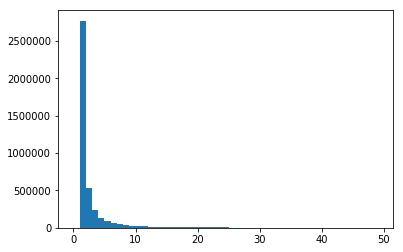

In [15]:
userCounts = userCountsDf.rdd.map(lambda r: r[0]).collect()
plt.hist(userCounts, bins=range(0, 50));

In [13]:
listeningCountsDf = data.select("user_id", "track_id") \
    .groupBy("track_id") \
    .agg(count("user_id").alias("count")) \
    .select("count")

listeningCountsDf.select(mean("count").alias("average listenings per track")).show()

+----------------------------+
|average listenings per track|
+----------------------------+
|           6.441337581001098|
+----------------------------+



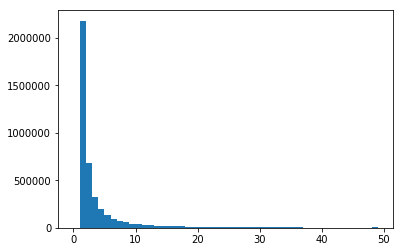

In [14]:
listeningCounts = listeningCountsDf.rdd.map(lambda r: r[0]).collect()
plt.hist(listeningCounts, bins=range(0, 50));

## Evaluation split

In [10]:
if not loadFeatures and not loadIndexed:
    random.seed(1)
    testUserIds = random.sample(data.select("user_id").distinct().orderBy("user_id").rdd.map(lambda r: r[0]).collect(), 10000)


def trainTestSplit(data):
    train = data.where(~col("user_id").isin(testUserIds))
    test = data.where(col("user_id").isin(testUserIds))
    return train, test



def lastSessionSplit(data):
    maxTimestampWindow = sparkMax("s_timestamp").over(Window.partitionBy("user_id"))
    data = data.withColumn("maxTimestamp", maxTimestampWindow)
    previous = data.where(col("s_timestamp") < col("maxTimestamp")).drop("maxTimestamp")
    last = data.where(col("s_timestamp") == col("maxTimestamp")).drop("maxTimestamp")
    return previous, last


def seedsCtxSplit(data):
    previous, last = lastSessionSplit(data)
    maxPosWindow = sparkMax("pos").over(Window.partitionBy("user_id"))
    last = last.withColumn("maxPos", maxPosWindow)
    seeds = previous.union(last.where(col("pos") < col("maxPos")).drop("maxPos"))
    context = last.where(col("pos") == col("maxPos")).drop("maxPos")
    return seeds, context
                

def lastTrackSplit(data, valSplit=False):
    train, test = trainTestSplit(data)
    testSeeds, test = seedsCtxSplit(test)
    if valSplit:
        valSeeds, val = seedsCtxSplit(testSeeds)
        return train.unionAll(valSeeds), valSeeds, val
    return train.unionAll(testSeeds), testSeeds, test

In [11]:
if not loadFeatures and not loadIndexed:
    trainData, valSeedsData, valData = lastTrackSplit(data, valSplit=valSplit)

## Preprocessing

In [12]:
keepCols = ["s_id"]
userIndexerCols = [("user_id", "userid"), ("gender", "genderid"), ("age", "ageid"), ("country", "countryid")]
itemIndexerCols = [("track_id", "traid"), ("album_id", "albid"), ("artist_id", "artid")]
prevItemIndexerCols = [("prev_" + i, "prev_" + o) for i, o in itemIndexerCols]
indexerCols = userIndexerCols + itemIndexerCols + prevItemIndexerCols


def saveIndexerModels(models, modelPathFormat):
    return [model.save(modelPathFormat.format(i))
            for model, (i, o) in zip(models, userIndexerCols + itemIndexerCols + prevItemIndexerCols)]   

    
def loadIndexerModels(modelPathFormat):
    return [StringIndexerModel.load(modelPathFormat.format(i))
            for i, o in userIndexerCols + itemIndexerCols + prevItemIndexerCols]


def fitIndexerModels(data):
    userIndexers = [StringIndexer(inputCol=i, outputCol=o, handleInvalid="keep").fit(data)
                    for i, o in userIndexerCols]
    itemIndexers = [StringIndexer(inputCol=i, outputCol=o, handleInvalid="keep").fit(data)
                    for i, o in itemIndexerCols]
    prevItemIndexers = [ii.copy({ii.inputCol: i, ii.outputCol: o})
                        for (ii, (i, o)) in zip(itemIndexers, prevItemIndexerCols)]

    return userIndexers + itemIndexers + prevItemIndexers


def toIndexed(data, indexerModels):
    for model, modelCols in zip(indexerModels, indexerCols):
        data = model.transform(data)
    return data.select(*([col(o).cast("integer").alias(o) for i, o in indexerCols]) + keepCols)

In [13]:
def loadEncoderModels(modelPaths):
    return tuple(WeightHotEncoderModel.load(modelPath) for modelPath in modelPaths)
    

def fitEncoderModels(data):
    userColdStartGroupCols = ["s_id"]
    userColdStartCols = ["traid"]
    userColdStartWeights = [1.0]
    userColdStartEncoderModel = WeightHotEncoderEstimator(
        weights=userColdStartWeights, inputCols=userColdStartCols,
        outputCols=[c + "_cold_encoded" for c in userColdStartCols],
        groupCols=userColdStartGroupCols, groupWeighting="sqrt"
    ).fit(data)
    
    # dropLast, missing user features are simply ignored, no problem for ranking
    userCols = ["userid", "genderid", "ageid", "countryid"]
    userWeights = [1.0, 0.5, 0.25, 0.25]
    userEncoderModel = WeightHotEncoderEstimator(
        weights=userWeights, inputCols=userCols,
        outputCols=[c + "_encoded" for c in userCols], dropLast=True
    ).fit(data)
    
    # missing item features are mapped to the missing feature index
    itemCols = ["traid", "albid", "artid"]
    itemWeights = [1.0, 1.0, 1.0]
    itemEncoderModel = WeightHotEncoderEstimator(
        weights=itemWeights, inputCols=itemCols,
        outputCols=[c + "_encoded" for c in itemCols], dropLast=False
    ).fit(data)

    # dropLast, missing user features are simply ignored, no problem for ranking
    ctxitemCols = ["prev_traid", "prev_albid", "prev_artid"]
    ctxitemWeights = itemWeights
    ctxitemEncoderModel = itemEncoderModel.copy({
        itemEncoderModel.weights: ctxitemWeights,
        itemEncoderModel.inputCols: ctxitemCols,
        itemEncoderModel.outputCols: [c + "_encoded" for c in ctxitemCols],
        itemEncoderModel.dropLast: True,
        itemEncoderModel.handleInvalid: "keep"
    })
    
    return userColdStartEncoderModel, userEncoderModel, itemEncoderModel, ctxitemEncoderModel

In [14]:
if not loadFeatures:
    
    # loading / fitting and saving indexer and indexing
    if loadIndexed:
        trainData = spark.read.parquet(indexedTrainDataPath)
        valSeedsData = spark.read.parquet(indexedValSeedsDataPath)
        valData = spark.read.parquet(indexedValDataPath)

    else:
        if loadIndexers:
            indexerModels = loadIndexerModels(indexerModelPathFormat)
        else:
            indexerModels = fitIndexerModels(trainData)
            if saveIndexers:
                saveIndexerModels(indexerModels, indexerModelPathFormat)

        trainData = toIndexed(trainData, indexerModels)
        valSeedsData = toIndexed(valSeedsData, indexerModels)
        valData = toIndexed(valData, indexerModels)

        if saveIndexed:
            trainData.coalesce(400).write.save(indexedTrainDataPath, format="parquet", mode="overwrite")
            valSeedsData.coalesce(400).write.save(indexedValSeedsDataPath, format="parquet", mode="overwrite")
            valData.coalesce(400).write.save(indexedValDataPath, format="parquet", mode="overwrite")

In [15]:
if not loadFeatures:
    
    # loading / fitting and saving encoder
    if loadEncoders:
        encoderModels = loadEncoderModels(encoderModelPaths)
    else:
        encoderModels = fitEncoderModels(trainData)
        if saveEncoders:
            for model, modelPath in zip(encoderModels, encoderModelPaths):
                model.save(modelPath)

In [16]:
def toFeatures(data, encoderModels, queryctxData=None, sharedItemFeatures=False,
               allUserColdStartWeights=[1.0],
               userColdStartWeighting="sqrt",
               allUserWeights=[1.0, 0.5, 0.25, 0.25],
               allCtxitemWeights=[1.0, 1.0, 1.0],
               allItemWeights=[1.0, 1.0, 1.0],
               coldStartUserCols=[],
               userCols=["userid", "genderid", "ageid", "countryid"],
               ctxitemCols=["prev_traid", "prev_albid", "prev_artid"],
               itemCols=["traid", "albid", "artid"]):
    
    userColdStartEncoderModel, userEncoderModel, itemEncoderModel, ctxitemEncoderModel = encoderModels
    
    encodedColdStartUserCols = [c + "_cold_encoded" for c in coldStartUserCols]
    encodedUserCols = [c + "_encoded" for c in userCols]
    encodedItemCols = [c + "_encoded" for c in itemCols]
    encodedCtxitemCols = [c + "_encoded" for c in ctxitemCols]
    
    # hot encode
    if coldStartUserCols:
        data = userColdStartEncoderModel \
            .setWeights(allUserColdStartWeights) \
            .setGroupWeighting(userColdStartWeighting) \
            .transform(data)
    
    if queryctxData:
        if coldStartUserCols:
            firstColdStartUserCols = [first(c).alias(c) for c in encodedColdStartUserCols]
            data = data.groupBy("s_id") \
                .agg(*firstColdStartUserCols) \
                .select("s_id", *encodedColdStartUserCols) \
                .join(queryctxData, "s_id")
    else:
        data = itemEncoderModel.setWeights(allItemWeights).transform(data)
    
    if userCols: 
        data = userEncoderModel.setWeights(allUserWeights).transform(data)
        
    if ctxitemCols:
        data = ctxitemEncoderModel.setWeights(allCtxitemWeights).transform(data)
        
    # assemble feature vectors of required hot-encoded columns into combined feature vectors
    userInputCols = encodedCtxitemCols + encodedColdStartUserCols + encodedUserCols
    userAssembler = VectorAssembler(inputCols=userInputCols, outputCol="userctxfeatures")
    data = userAssembler.transform(data)

    if not queryctxData:
        itemInputCols = encodedItemCols
        itemAssembler = VectorAssembler(inputCols=itemInputCols, outputCol="itemfeatures")
        data = itemAssembler.transform(data)

    # rename columns to Glint-FMPair names
    cols = [col("userctxfeatures"), col("userid").cast("int").alias("userid")]
    
    if not queryctxData and sharedItemFeatures:
        cols += [expr("resizeVector(itemfeatures,userctxfeatures)").alias("itemfeatures"), 
                 col("traid").cast("int").alias("itemid"),
                 col("albid").cast("int"), col("artid").cast("int")]
    elif not queryctxData:
        cols += [col("itemfeatures"), col("traid").cast("int").alias("itemid"),
                 col("albid").cast("int"), col("artid").cast("int")]
    
    return data.select(*cols)

## Evaluation metrics

In [17]:
def dcg(itemid, recs):
    return sum(1.0 / log2(i + 2) if rec["itemid"] == itemid else 0.0
               for i, rec in enumerate(recs))

def hitRate(itemid, recs):
    return 1.0 if recs[0]["itemid"] == itemid else 0


dcgUdf = udf(dcg)
hitRateUdf = udf(hitRate)


def evaluateModel(queryfeatures, evaldata, model, withHitRates=False, traindata=None):
    if traindata:
        recdata = model.recommendForUserSubset(queryfeatures, traindata, 500)
    else:
        recdata = model.recommendForUserSubset(queryfeatures.coalesce(80), 500)
    scores = evaldata.join(recdata, "userid") \
        .select(hitRateUdf("itemid", "recommendations").alias("hitRate"), \
                dcgUdf("itemid", "recommendations").alias("dcg")) \
        .select(mean(col("hitRate")), mean(col("dcg"))) \
        .first()
    
    hitRate = scores[0]
    ndcg = scores[1]
    
    if withHitRates:
        
        numUsers = evaldata.select("userid").dropDuplicates().count()
        
        hitRates = evaldata.join(recdata, "userid") \
            .select("itemid", posexplode("recommendations")) \
            .where(col("itemid") == col("col.itemid")) \
            .groupBy("pos") \
            .agg(count("itemid").alias("hitRate"))
         
        hitRates = sc.range(0, 500).map(lambda p: Row(pos=p)).toDF() \
            .join(hitRates, on="pos", how="left") \
            .fillna(0.0, subset=["hitRate"]) \
            .select("pos", sparkSum("hitRate").over(Window.orderBy("pos")).alias("hitRate")) \
            .orderBy("pos") \
            .select("hitRate") \
            .rdd \
            .map(lambda r: r[0] / numUsers) \
            .collect()
        
        return hitRate, ndcg, hitRates
    
    return hitRate, ndcg

## Evaluation

In [ ]:
trainFeaturesPath = "30Music-L-trainfeatures.parquet"
valqueryFeaturesPath = "30Music-L-valqueryfeatures.parquet"

if loadFeatures:
    trainFeatures = spark.read.parquet(trainFeaturesPath).coalesce(400).cache()
    valqueryFeatures = spark.read.parquet(valqueryFeaturesPath)
    valFeatures = spark.read.parquet(indexedValDataPath).select(col("userid"), col("traid").alias("itemid"))
else:
    trainFeatures = toFeatures(trainData, encoderModels,
                               userCols=["userid"], itemCols=["traid"], ctxitemCols=[])
    valqueryFeatures = toFeatures(valData, encoderModels, 
                                  queryctxData=valData,
                                  userCols=["userid"], ctxitemCols=[])
    valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))
    
    if saveFeatures:
        trainFeatures.coalesce(400).write.save(trainFeaturesPath, format="parquet", mode="overwrite")
        valqueryFeatures.coalesce(400).write.save(valqueryFeaturesPath, format="parquet", mode="overwrite")

In [ ]:
metadataPath = "30Music-L.meta"
metadataPathExp = "30Music-L-exp.meta"

In [ ]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=256, stepSize=0.1, linearReg=0.1, factorsReg=0.003, numDims=50,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="uniform", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 769.81630s fit time
# 0.003800 hit rate
# 0.027909 NDCG

In [ ]:
linearRegs = [0.001, 0.01, 0.03, 0.3]
for linearReg in linearRegs:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=linearReg, factorsReg=0.003, numDims=50,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 769.92820s fit time
# 0.002400 hit rate
# 0.026507 NDCG
# 1070.65501s fit time
# 0.002600 hit rate
# 0.028123 NDCG
# 769.09358s fit time
# 0.002500 hit rate
# 0.027509 NDCG
# 744.53656s fit time
# 0.002800 hit rate
# 0.028217 NDCG

In [ ]:
factorRegs = [0.001, 0.01, 0.03, 0.1]
for factorReg in factorRegs:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=0.3, factorsReg=factorReg, numDims=50,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1112.41945s fit time
# 0.002300 hit rate
# 0.025004 NDCG
# 761.25902s fit time
# 0.002600 hit rate
# 0.025468 NDCG
# 740.64713s fit time
# 0.001600 hit rate
# 0.016367 NDCG
# 793.63948s fit time
# 0.000000 hit rate
# 0.002894 NDCG

In [ ]:
ks = [100, 150, 200, 250, 300, 350, 400]
kNdcgs = []
kFitTimes = []
for k in ks:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=0.3, factorsReg=0.003, numDims=k,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("k {}:".format(k))
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))
    kNdcgs.append(ndcg)
    kFitTimes.append(fitTime)

# k 100:
# 826.48912s fit time
# 0.005400 hit rate
# 0.037765 NDCG
# k 150:
# 859.48242s fit time
# 0.005900 hit rate
# 0.041183 NDCG
# k 200:
# 916.39787s fit time
# 0.006100 hit rate
# 0.042941 NDCG
# k 250:
# 976.08624s fit time
# 0.006000 hit rate
# 0.044643 NDCG
# k 300:
# 1388.20570s fit time
# 0.005300 hit rate
# 0.044574 NDCG
# k 350:
# 1183.39373s fit time
# 0.006700 hit rate
# 0.046190 NDCG
# k 400:
# 3007.96437s fit time
# 0.007800 hit rate
# 0.048447 NDCG

In [ ]:
plt.close()

In [ ]:
plt.figure(figsize=(6, 3))

ks = [50, 100, 150, 200, 250, 300, 350, 400]
kNdcgs = [0.028217, 0.037765, 0.041183, 0.042941, 0.044643, 0.044574, 0.046190, 0.048447]

plt.plot(ks, kNdcgs, "o--", color="red")
plt.xticks(ks)
plt.ylim(bottom=0.02, top=0.05)
plt.grid(True, axis="y")

plt.ylabel("NDCG")
plt.xlabel("k")
plt.title("30Music Listenings")
plt.savefig("30music-l_ndcgs_k.png", bbox_inches = "tight");

In [ ]:
samplingCols = ["itemid", "albid", "artid",
                "", "itemid", "albid", "artid",
                "", "itemid", "albid", "artid",
                "", "itemid", "albid", "artid"]
samplers = ["uniform", "uniform", "uniform",
            "exp", "exp", "exp", "exp",
            "crossbatch", "crossbatch", "crossbatch", "crossbatch",
            "crossbatch", "crossbatch", "crossbatch", "crossbatch"]
lrs = [0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1,
       1.0, 1.0, 1.0, 1.0,
       1.0, 1.0, 1.0, 1.0]
maxIters = [100, 100, 100,
            100, 100, 100, 100,
            10, 10, 10, 10,
            10, 10, 10, 10]
batchSizes = [256, 256, 256,
              256, 256, 256, 256,
              256, 256, 256, 256,
              1024, 1024, 1024, 1024]

metadataPaths = [metadataPath, metadataPath, metadataPath,
                 metadataPathExp, metadataPathExp, metadataPathExp, metadataPathExp,
                 metadataPath, metadataPath, metadataPath, metadataPath,
                 metadataPath, metadataPath, metadataPath, metadataPath]

for samplingCol, sampler, lr, maxIter, batchSize, metadataPath in zip(
    samplingCols, samplers, lrs, maxIters, batchSizes, metadataPaths):
    
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=batchSize, stepSize=lr, linearReg=0.3, factorsReg=0.003, numDims=300,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=maxIter,
        samplingCol=samplingCol, sampler=sampler, filterItemsCol="",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{} {}:".format(sampler, samplingCol))
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))
    
# uniform itemid:
# 1459.55878s fit time
# 0.006300 hit rate
# 0.045079 NDCG
# uniform albid:
# 1028.89447s fit time
# 0.006400 hit rate
# 0.045283 NDCG
# uniform artid:
# 1009.17636s fit time
# 0.006700 hit rate
# 0.044768 NDCG
# exp :
# 2156.65964s fit time
# 0.006800 hit rate
# 0.048674 NDCG
# exp itemid:
# 1096.18417s fit time
# 0.006600 hit rate
# 0.048557 NDCG
# exp albid:
# 993.02315s fit time
# 0.007200 hit rate
# 0.049352 NDCG
# exp artid:
# 1023.24253s fit time
# 0.005600 hit rate
# 0.048277 NDCG
# crossbatch :
# 864.01053s fit time
# 0.004700 hit rate
# 0.042598 NDCG
# crossbatch itemid:
# 1364.53078s fit time
# 0.004800 hit rate
# 0.042796 NDCG
# crossbatch albid:
# 1285.68711s fit time
# 0.004400 hit rate
# 0.043078 NDCG
# crossbatch artid:
# 1333.09099s fit time
# 0.004700 hit rate
# 0.042121 NDCG
# crossbatch :
# 1621.64429s fit time
# 0.006600 hit rate
# 0.050347 NDCG
# crossbatch itemid:
# 1423.17732s fit time
# 0.007100 hit rate
# 0.049972 NDCG
# crossbatch albid:
# 1432.14319s fit time
# 0.007400 hit rate
# 0.051115 NDCG
# crossbatch artid:
# 1566.38691s fit time
# 0.006900 hit rate
# 0.050598 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"], itemCols=["traid", "albid", "artid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"], ctxitemCols=[])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1241.20043s fit time
# 0.003100 hit rate
# 0.046677 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid", "genderid", "ageid", "countryid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid", "genderid", "ageid", "countryid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 2642.53858s fit time
# 0.003400 hit rate
# 0.044699 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid"],
                           ctxitemCols=["prev_traid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-prev.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 2557.10558s fit time
# 0.158100 hit rate
# 0.242465 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-prev-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 4998.96782s fit time
# 0.000000 hit rate
# 0.000350 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-prev-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1741.04306s fit time
# 0.055400 hit rate
# 0.192885 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid", "genderid", "ageid", "countryid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid", "genderid", "ageid", "countryid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1615.79176s fit time
# 0.056800 hit rate
# 0.193696 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           userCols=["userid"],
                           itemCols=["traid"],
                           ctxitemCols=["prev_traid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, sharedItemFeatures=True,
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-trans-prev.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1591.14356s fit time
0.042500 hit rate
0.192585 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           userCols=["userid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-trans-prev-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

2633.81627s fit time
0.039100 hit rate
0.183885 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           userCols=["userid", "genderid", "ageid", "countryid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              userCols=["userid", "genderid", "ageid", "countryid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy(terminateOtherClients=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 2767.81222s fit time
# 0.039000 hit rate
# 0.181736 NDCG

In [ ]:
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           coldStartUserCols=["traid"],
                           userCols=["userid", "genderid", "ageid", "countryid"],
                           itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]
                          ).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              coldStartUserCols=["traid"],
                              userCols=["userid", "genderid", "ageid", "countryid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-trans-prev-all-sessions.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

## Final evaluation

In [18]:
model = TfIdfKNN(filterUserItems=False).fit(
    trainData.select(col("userid"), col("traid").alias("itemid"))
)

ks = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
for k in ks:
    hitRate, ndcg = evaluateModel(
        valSeedsData.select(col("userid"), col("traid").alias("itemid")),
        valData.select(col("userid"), col("traid").alias("itemid")),
        model.setK(k))
    print("{} k\n{:.6f} hit rate\n{:.6f} NDCG".format(k, hitRate, ndcg))

10 k
0.007000 hit rate
0.073998 NDCG
50 k
0.007500 hit rate
0.078863 NDCG
100 k
0.008200 hit rate
0.079441 NDCG
150 k
0.007700 hit rate
0.078880 NDCG
200 k
0.007900 hit rate
0.078438 NDCG
250 k
0.007500 hit rate
0.077819 NDCG
300 k
0.007800 hit rate
0.077433 NDCG
350 k
0.007800 hit rate
0.076937 NDCG
400 k
0.007800 hit rate
0.076341 NDCG
450 k
0.007800 hit rate
0.075886 NDCG
500 k
0.007500 hit rate
0.075045 NDCG
1000 k
0.007100 hit rate
0.071154 NDCG


In [20]:
model = TfIdfKNN(filterUserItems=False).fit(
    trainData.select(col("userid"), col("traid").alias("itemid"))
)

hitRate, knnNdcg, knnHitRates = evaluateModel(
    valSeedsData.select(col("userid"), col("traid").alias("itemid")),
    valData.select(col("userid"), col("traid").alias("itemid")),
    model.setK(100), withHitRates=True)
print("{:.6f} hit rate\n{:.6f} NDCG".format(hitRate, knnNdcg))

0.007600 hit rate
0.079282 NDCG


In [18]:
fitStart = time.time()
model = PopRank(filterUserItems=False, allItemsFrequency=True).fit(
    trainData.select("userid", col("traid").alias("itemid"))
)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, popRankNdcg, popRankHitRates = evaluateModel(
    valSeedsData.select("userid", col("traid").alias("itemid")),
    valData.select("userid", col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, popRankNdcg))

0.47085s fit time
0.000600 hit rate
0.007707 NDCG


In [19]:
fitStart = time.time()
model = SAGH(filterUserItems=False, allItemsFrequency=True).fit(
    trainData.select("userid", col("traid").alias("itemid"), "artid")
)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, saghNdcg, saghHitRates = evaluateModel(
    valSeedsData.select("userid", col("traid").alias("itemid"), "artid"),
    valData.select("userid", col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, saghNdcg))

0.10368s fit time
0.002800 hit rate
0.039787 NDCG


In [18]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-final.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

8308.21255s fit time
0.003300 hit rate
0.038180 NDCG


In [18]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-final.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

with open("30Music-L-final-hitRates2.pickle", "wb") as f:
    pickle.dump(hitRates, f)

1028.34171s fit time
0.009000 hit rate
0.050906 NDCG


In [19]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["userid"],
                           itemCols=["traid"],
                           ctxitemCols=["prev_traid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valData, encoderModels, 
                              queryctxData=valData,
                              userCols=["userid"],
                              ctxitemCols=["prev_traid"])
valFeatures = valData.select(col("userid"), col("traid").alias("itemid"))


metadataPath = "30Music-L-final-prev.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.3, factorsReg=0.003, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

with open("30Music-L-final-prev-hitRates2.pickle", "wb") as f:
    pickle.dump(hitRates, f)

1271.50239s fit time
0.053200 hit rate
0.140893 NDCG


In [21]:
with open("30Music-L-final-hitRates2.pickle", "rb") as f:
    hitRates = pickle.load(f)

with open("30Music-L-final-prev-hitRates2.pickle", "rb") as f:
    hitRates2 = pickle.load(f)

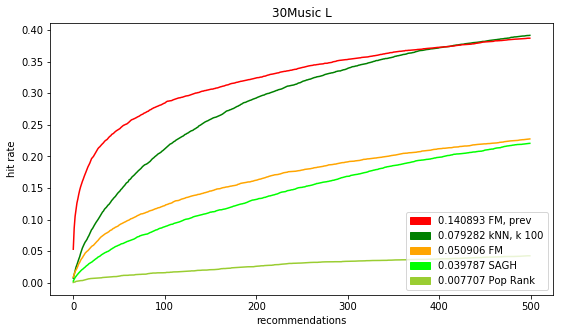

In [28]:
plt.figure(figsize=(9, 5))
plt.plot(popRankHitRates, color="yellowgreen")
plt.plot(saghHitRates, color="lime")
plt.plot(knnHitRates, color="green")
plt.plot(hitRates, color="orange")
plt.plot(hitRates2, color="red")

yellowgreen_patch = mpatches.Patch(color="yellowgreen",
                                   label="{:.6f} Pop Rank".format(popRankNdcg))
green_patch = mpatches.Patch(color="lime",
                             label="{:.6f} SAGH".format(saghNdcg))
dgreen_patch = mpatches.Patch(color="green",
                              label="{:.6f} kNN, k 100".format(knnNdcg))
orange_patch = mpatches.Patch(color="orange",
                              label="0.050906 FM")
red_patch = mpatches.Patch(color="red",
                           label="0.140893 FM, prev")
patches = [red_patch, dgreen_patch, orange_patch,
           green_patch, yellowgreen_patch]
plt.legend(handles=patches, loc="lower right")

plt.ylabel("hit rate")
plt.xlabel("recommendations")
plt.title("30Music L")

plt.savefig("30Music-L-baselines.png", bbox_inches="tight");